In [1]:
import numpy as np
import sympy as smp
import pandas as pd
from numpy import arctan
from scipy import integrate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

Define all necessary variables:

* Time $t$
* Mass of top, bottom and foundation $m_t$, $m_b$, $m_f$
* Moment of inertia of foundation+top+bottom mass $I$
* Gravitational acceleration $g$
* Spring constants $k$, $k_h$, $k_\phi$ 
* Damping constants $c$, $c_h$, $c_\phi$
* Height of floor $h$
* Coefficient of friction $\mu$
* Frictional friction force $F_f$

Then define the 5 free variables $u_g$, $u_o$, $\phi$, $u_b$, $u_t$

1. Make them functions of time
2. Define first derivatives
3. Define second derivatives

In [2]:
t, mt, mb, mf, I, g, kt, kb, kh, kp, = smp.symbols('t m_t m_b m_f I g k_t k_b k_h k_\phi')

In [3]:
ct, cb, ch, cp, h, mu, Ff, eps = smp.symbols('c_t c_b c_h c_\phi h \mu F_f \epsilon')

In [4]:
ug, uo, phi, ub, ut = smp.symbols(r'u_g, u_o, \phi, u_b, u_t', cls=smp.Function)

ug = ug(t)
ug_d = smp.diff(ug, t)
ug_dd = smp.diff(smp.diff(ug, t), t)

uo = uo(t)
uo_d = smp.diff(uo, t)
uo_dd = smp.diff(smp.diff(uo, t), t)

phi = phi(t)
phi_d = smp.diff(phi, t)
phi_dd = smp.diff(smp.diff(phi, t), t)

ub = ub(t)
ub_d = smp.diff(ub, t)
ub_dd = smp.diff(smp.diff(ub, t), t)

ut = ut(t)
ut_d = smp.diff(ut, t)
ut_dd = smp.diff(smp.diff(ut, t), t)

Define the Lagrangian

$$ L = T - V $$

where 

* T = Kinetic energy of top, bottom and foundation
* V = Potential energy of all springs

In [5]:
T = 1/2 * mt * (ug_d + uo_d + h*phi_d + ut_d)**2 + 1/2 * mb * (ug_d + uo_d + ub_d)**2 + 1/2 * mf * (ug_d + uo_d)**2 + \
    1/2 * I * phi_d**2
V = 1/2 * kb * ub**2 + 1/2 * kt * (ut - ub)**2 + 1/2 * kh * uo**2 + 1/2 * kp * phi**2
L = T-V

In [6]:
V

0.5*k_\phi*\phi(t)**2 + 0.5*k_b*u_b(t)**2 + 0.5*k_h*u_o(t)**2 + 0.5*k_t*(-u_b(t) + u_t(t))**2

Compute Lagrange's equations

 $ \dfrac{d}{dt} \dfrac{dL}{d\dot{q_i}} - \dfrac{dL}{dq_i} = Q_i $

where $q_i$ is each of $u_t$, $u_b$, $u_o$, $\phi$ and $Q_i$ are the generalized non-conservative forces that includes damping and friction

In [7]:
LE1 = -smp.diff(L, ut) + smp.diff(smp.diff(L, ut_d), t) + ct * (ut_d - ub_d)
LE1 = LE1.simplify()

In [8]:
LE2 = -smp.diff(L, ub) + smp.diff(smp.diff(L, ub_d), t) + ct * (-ut_d + ub_d) + cb * ub_d \
      + (1/smp.pi)*mu*2*(mt+mb)*g*smp.atan(eps*ub_d)
LE2 = LE2.simplify()

In [9]:
LE3 = -smp.diff(L, uo) + smp.diff(smp.diff(L, uo_d), t) + ch * uo_d 
LE3 = LE3.simplify()

In [10]:
LE4 = -smp.diff(L, phi) + smp.diff(smp.diff(L, phi_d), t) + cp * phi_d
LE4 = LE4.simplify()

In [11]:
LE2

(2*\mu*g*(m_b + m_t)*atan(\epsilon*Derivative(u_b(t), t)) + pi*(c_b*Derivative(u_b(t), t) + c_t*(Derivative(u_b(t), t) - Derivative(u_t(t), t)) + 1.0*k_b*u_b(t) + k_t*(u_b(t) - u_t(t)) + m_b*(Derivative(u_b(t), (t, 2)) + Derivative(u_g(t), (t, 2)) + Derivative(u_o(t), (t, 2)))))/pi

In [12]:
sols = smp.solve([LE1, LE2, LE3, LE4], (ut_dd, ub_dd, uo_dd, phi_dd),
                 rational=False)

In [13]:
sols[ut_dd]

-2.0*\mu*g*m_b*atan(\epsilon*Derivative(u_b(t), t))/(pi*m_f) - 2.0*\mu*g*m_t*atan(\epsilon*Derivative(u_b(t), t))/(pi*m_f) - 1.0*c_b*Derivative(u_b(t), t)/m_f + 1.0*c_h*Derivative(u_o(t), t)/m_f + 1.0*c_t*Derivative(u_b(t), t)/m_t - 1.0*c_t*Derivative(u_t(t), t)/m_t - 1.0*k_b*u_b(t)/m_f + 1.0*k_h*u_o(t)/m_f + 1.0*k_t*u_b(t)/m_t - 1.0*k_t*u_t(t)/m_t + 1.0*c_\phi*h*Derivative(\phi(t), t)/I + 1.0*c_t*h**2*Derivative(u_b(t), t)/I - 1.0*c_t*h**2*Derivative(u_t(t), t)/I + 1.0*h**2*k_t*u_b(t)/I - 1.0*h**2*k_t*u_t(t)/I + 1.0*h*k_\phi*\phi(t)/I

If we solve for $d^2 q_i / d t^2$ where $q_i$ is each of $u_t$, $u_b$, $u_o$, $\phi$ then we can get two equation for each free variable. Defining $v_i$ as $dq_i/dt$ we get

* $dq_i/dt = v_i$
* $dv_i/dt = \text{long expressions obtained in the cell above}$

This turns our system of second order ODES into systems 1D differential equations.

**Example** $\frac{d^2 y}{dt^2} + 2\frac{dy}{dt} + y + 3 = 0$ (define $v = dy/dt$) gets turned into the system of 2 first order DE's (i) $dy/dt = v$ and  (ii) $dv/dt =  - 3 - y - 2v$

Specifically, define 

* $v_t \equiv du_t/dt$
* $v_b \equiv du_b/dt$
* $v_o \equiv du_o/dt$
* $\omega \equiv d\phi/dt$

Create python functions so that we can use with numerical methods

In [14]:
dvtdt_f = smp.lambdify((mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, uo, phi, ub, ut, uo_d, phi_d, ub_d, ut_d, ug_dd), sols[ut_dd])
dutdt_f = smp.lambdify(ut_d, ut_d)

dvbdt_f = smp.lambdify((mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, uo, phi, ub, ut, uo_d, phi_d, ub_d, ut_d, ug_dd), sols[ub_dd])
dubdt_f = smp.lambdify(ub_d, ub_d)

dvodt_f = smp.lambdify((mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, uo, phi, ub, ut, uo_d, phi_d, ub_d, ut_d, ug_dd), sols[uo_dd])
duodt_f = smp.lambdify(uo_d, uo_d)

dwdt_f = smp.lambdify((mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, uo, phi, ub, ut, uo_d, phi_d, ub_d, ut_d, ug_dd), sols[phi_dd])
dphidt_f = smp.lambdify(phi_d, phi_d)


Define our system of ODES with state space vector $S = (u_t, v_t, u_b, v_b, u_o, v_o, \phi, \omega)$

In [15]:
def dSdt(t, S, ug_dd):
    ut, vt, ub, vb, uo, vo, phi, w = S
    return [
        dutdt_f(vt),
        dvtdt_f(mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, uo, phi, ub, ut, vo, w, vb, vt, ug_dd),
        dubdt_f(vb),
        dvbdt_f(mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, uo, phi, ub, ut, vo, w, vb, vt, ug_dd),
        duodt_f(vo),
        dvodt_f(mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, uo, phi, ub, ut, vo, w, vb, vt, ug_dd),
        dphidt_f(w),
        dwdt_f(mt, mb, mf, I, g, kt, kb, kh, kp, ct, cb, ch, cp, h, mu, eps, uo, phi, ub, ut, vo, w, vb, vt, ug_dd),
    ]

Define constants and intial state space vector

In [80]:
g = 9.81
mt, mb, mf, I = 2.016e6, 2.106e6, 1.008e7, 4.872e9
kt, kb, kh, kp = 1e9, 0.05e9, 1.072e9, 2.268e12
ct, cb, ch, cp = 1.403e6, 4.712e5, 3.375e8, 2.202e11
h = 7.0
mu =0.2
eps = 700.0
S0 = [[0],[0],[0],[0],[0],[0],[0],[0]]
acc = [[0], [0], [0], [0]]

Plot the approximated Coulomb friction model 
 
$$F_f = \mu  m  g  * sign(v_{rel})$$ 
* Actual model:
$$
sign(v_{rel}) = \begin{cases} 1 & v_{rel}>0 \\ -1 & v_{rel}<0 \\ [-1,1] & v_{rel}=0 \end{cases}
$$
* Approximated model: 
$$sign(v_{rel}) = \frac{2}{\pi} \arctan(\epsilon v_{rel})$$

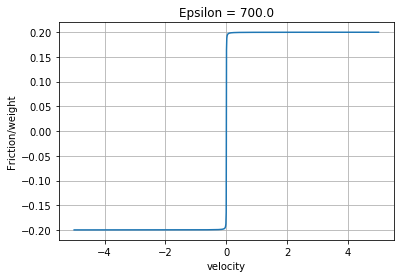

In [81]:
vel = np.linspace(-5, 5, 1000)
friction = (1/np.pi)*2*mu*np.arctan(eps*vel)
plt.plot(vel, friction)
plt.grid()
plt.xlabel("velocity")
plt.ylabel("Friction/weight") 
plt.title(f'Epsilon = {eps}')
plt.show()

Read earthquake data and store it in a pandas dataframe

In [82]:
df = pd.read_csv("elcentro_ns.csv",
                index_col = 0)

Improve resolution of earthquake data by linear interpolation to a smaller timestep

In [83]:
time_step = 0.001
t = np.arange(0, 53.74 + time_step, time_step)
inter = []
n = round(len(t)/len(df))

In [84]:
interp_f = interp1d(df.index,df.values.T[0], kind = 'linear')
inter = np.array(interp_f(t))*g

In [85]:
len(inter)

53741

Plot the interpolated earthquake data

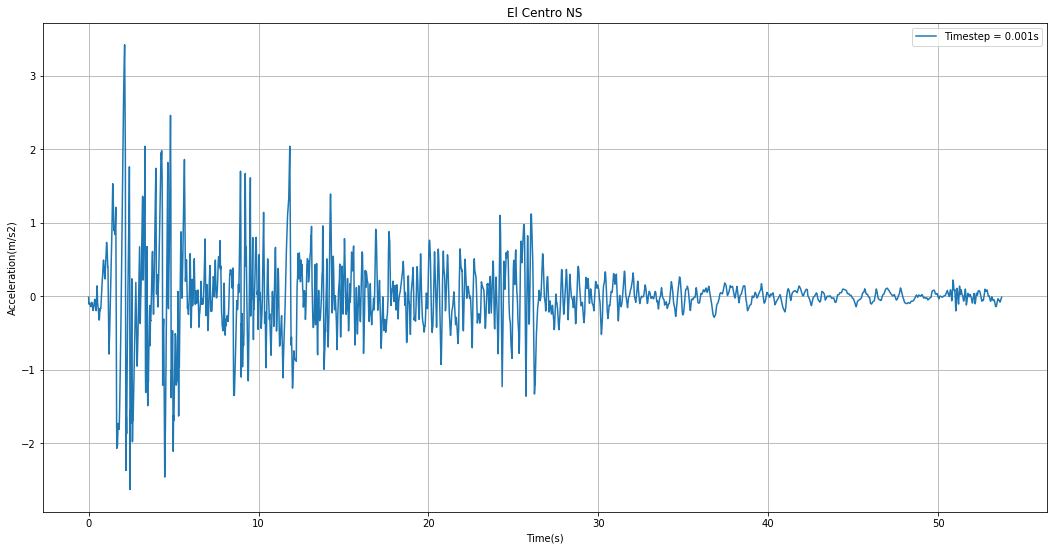

In [86]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, inter)
ax.legend([h1], [f'Timestep = {time_step}s'])
ax.set_ylabel('Acceleration(m/s2)')
ax.set_xlabel('Time(s)')
ax.grid()
plt.title('El Centro NS')
plt.show()

Integrate the earthquake acceleration to obtain to ground displacement data

In [87]:
vel_g = integrate.cumulative_trapezoid(inter, dx = time_step, initial = 0)
disp_g = integrate.cumulative_trapezoid(vel_g, dx = time_step, initial = 0)

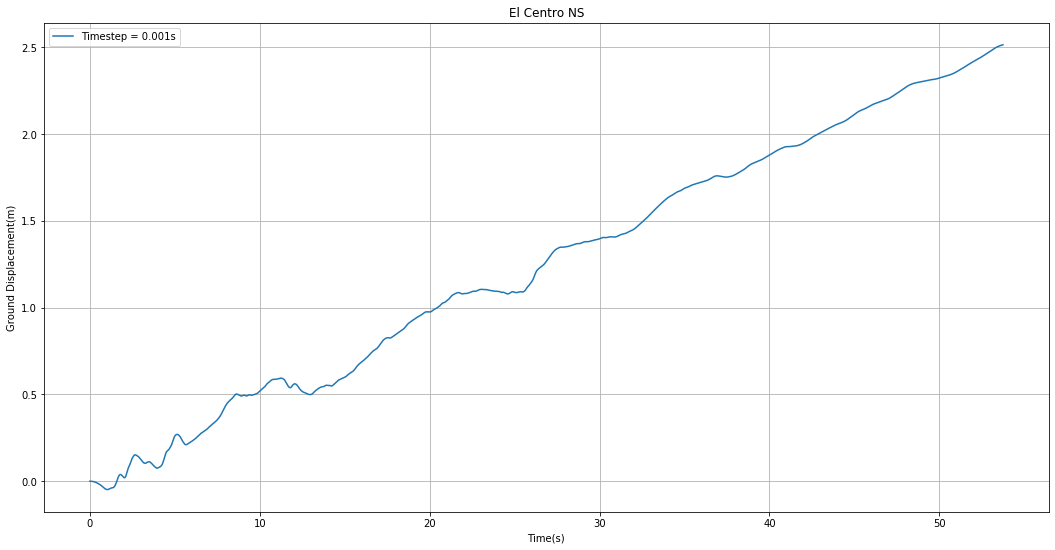

In [88]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(121)
h1, = ax.plot(t, disp_g)
ax.legend([h1], [f'Timestep = {time_step}s'])
ax.set_ylabel('Ground Displacement(m)')
ax.set_xlabel('Time(s)')
ax.grid()
plt.title('El Centro NS')
plt.show()

Solve the IVP for the interpolated earthquake data

In [89]:
for i in range(len(t)-1):
    ug_dd = inter[i]
    args = (ug_dd,)
    time = (t[i], t[i+1])
    #ans = integrate.odeint(dSdt, [a[i] for a in S0] , time, args)
    ans = integrate.solve_ivp(dSdt, time, [a[i] for a in S0], method = 'BDF', t_eval = time, args = args,
                   rtol = 1e-10, atol = 1e-10)
    for j in range(len(S0)):
        #S0[j].append(ans[1][j])
        S0[j].append(ans.y[j,1])

In [90]:
len(S0[0])

53741

Plot the structural responses

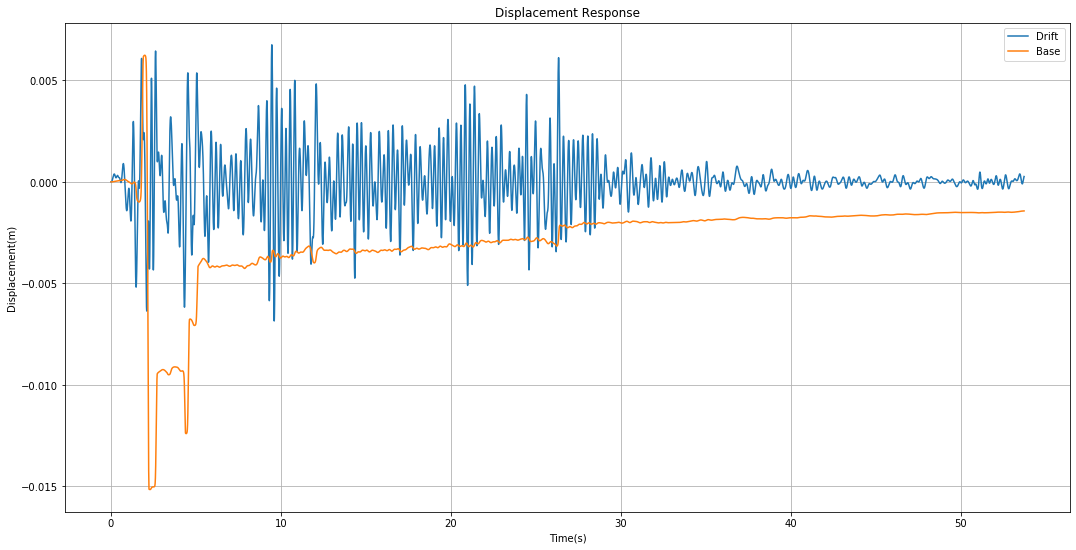

In [91]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, np.array(S0[0]) - np.array(S0[2]))
h2, = ax.plot(t, S0[2])
ax.legend([h1, h2], ['Drift', 'Base'])
ax.set_ylabel('Displacement(m)')
ax.set_xlabel('Time(s)')
ax.grid()
plt.title('Displacement Response')
plt.show()

In [92]:
abs_drift = np.absolute(np.array(S0[0]) - np.array(S0[2]))
drift_max = np.amax(abs_drift) * 1000
time_max = t[np.argmax(abs_drift)]
print(f'Max drift is {drift_max} mm at {time_max}s.') 

Max drift is 6.85057912996847 mm at 9.607s.


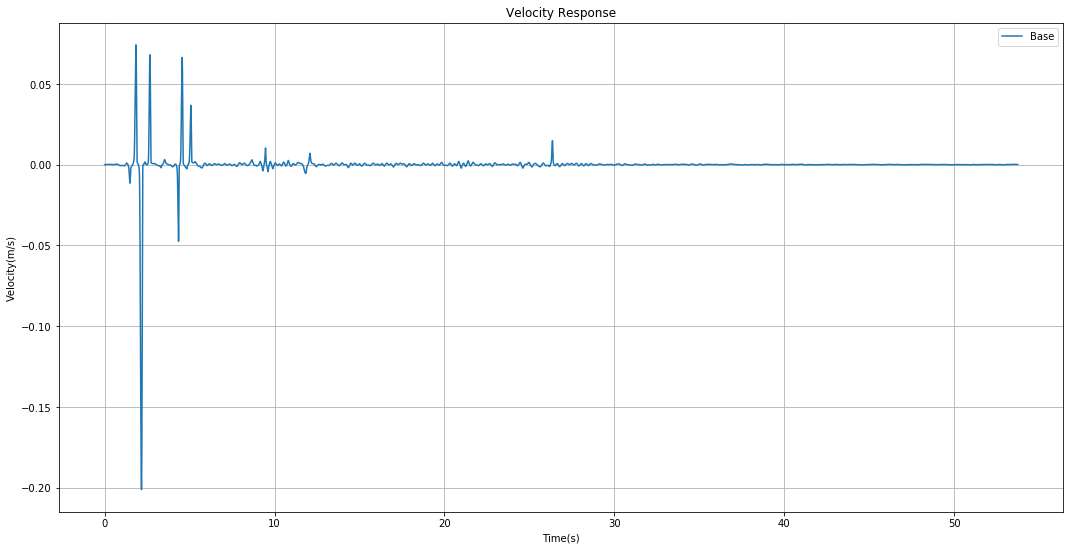

In [93]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h2, = ax.plot(t, S0[3])
ax.legend([h2], ['Base'])
ax.set_ylabel('Velocity(m/s)')
ax.set_xlabel('Time(s)')
ax.grid()
plt.title('Velocity Response')
plt.show()

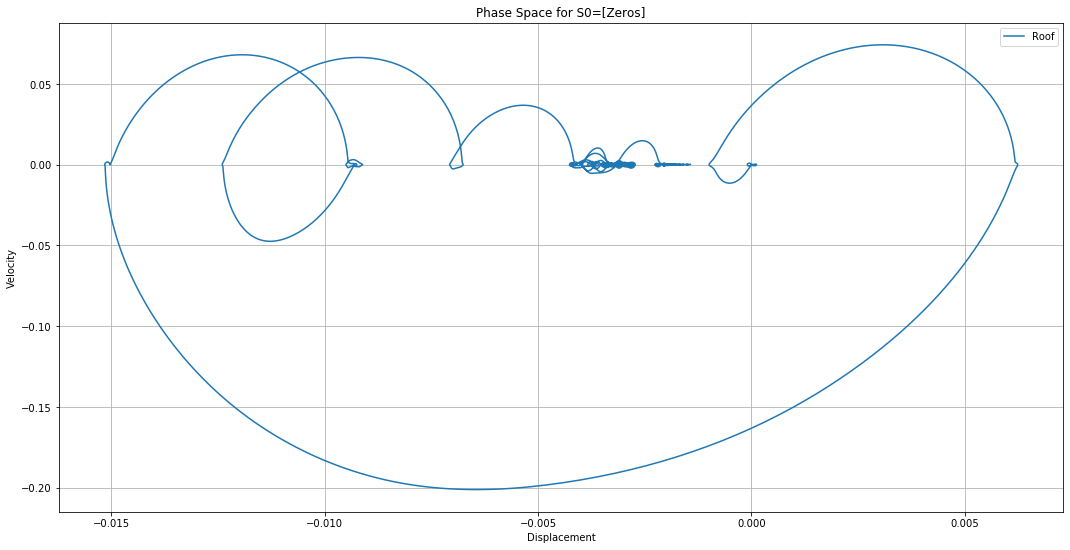

In [94]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h2, = ax.plot(S0[2],S0[3])
ax.legend([h1, ], ['Roof', ])
ax.set_ylabel('Velocity')
ax.set_xlabel('Displacement')
ax.grid()
plt.title('Phase Space for S0=[Zeros]')
plt.show()

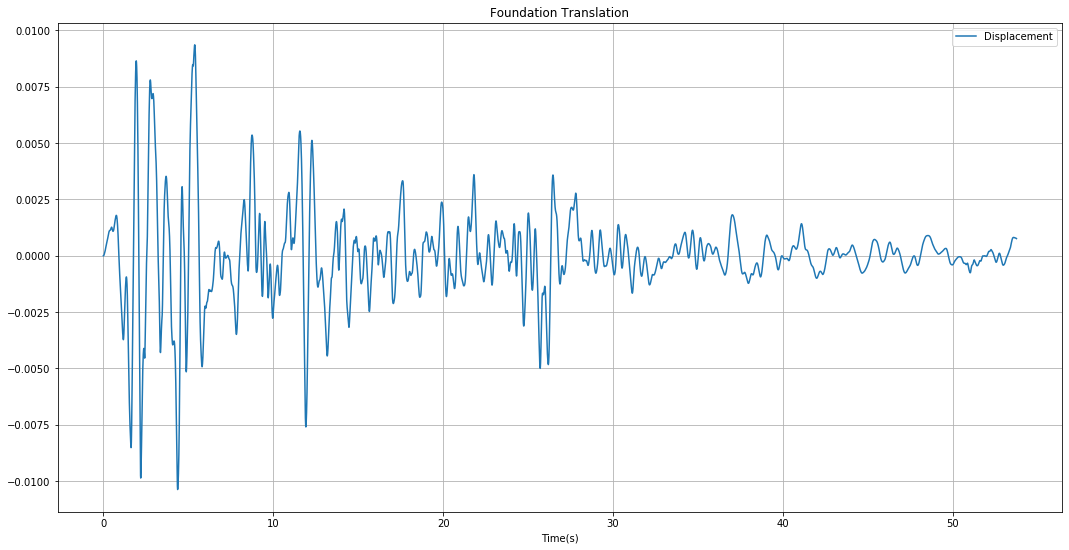

In [95]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, S0[4])
ax.legend([h1, ], ['Displacement', ])
ax.set_xlabel('Time(s)')
ax.grid()
plt.title('Foundation Translation')
plt.show()

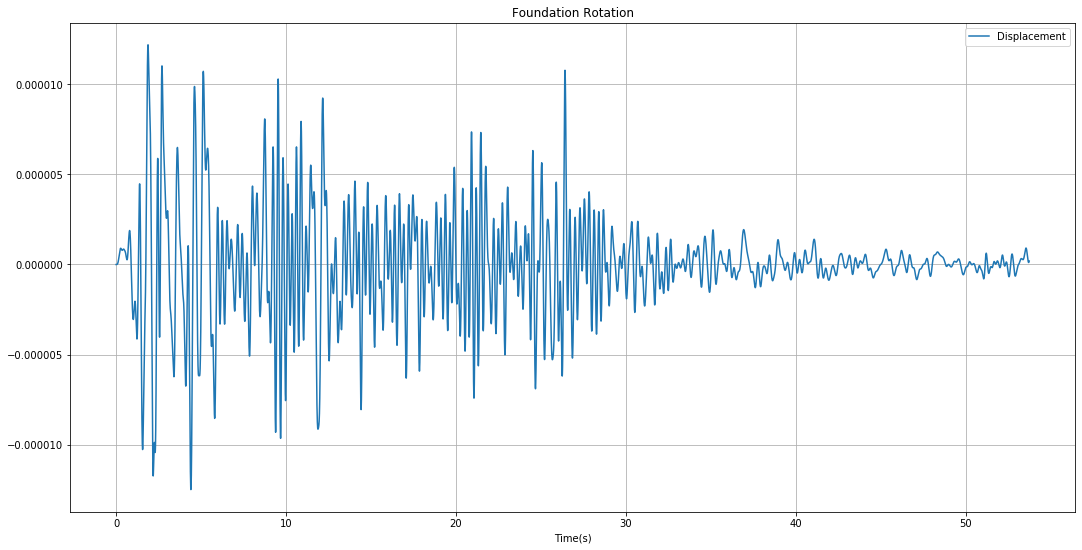

In [96]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, S0[6])
ax.legend([h1,], ['Displacement',])
ax.set_xlabel('Time(s)')
ax.grid()
plt.title('Foundation Rotation')
plt.show()

Find the response for fixed base building by assuming $\mu = 1000$. Construct a state-space vector $S1$ similar to $S0$

In [97]:
mu = 1000
S1 = [[0],[0],[0],[0],[0],[0],[0],[0]]

In [98]:
for i in range(len(t)-1):
    ug_dd = inter[i]
    args = (ug_dd,)
    time = (t[i], t[i+1])
    #ans = integrate.odeint(dSdt, [a[i] for a in S1] , time, args)
    ans = integrate.solve_ivp(dSdt, time, [a[i] for a in S1], method = 'BDF', t_eval = time, args = args,
                   rtol = 1e-10, atol = 1e-10)
    for j in range(len(S1)):
        #S1[j].append(ans[1][j])
        S1[j].append(ans.y[j,1])

In [99]:
len(S1[0])

53741

Plot the response of fixed base building and compare it with base isolated building

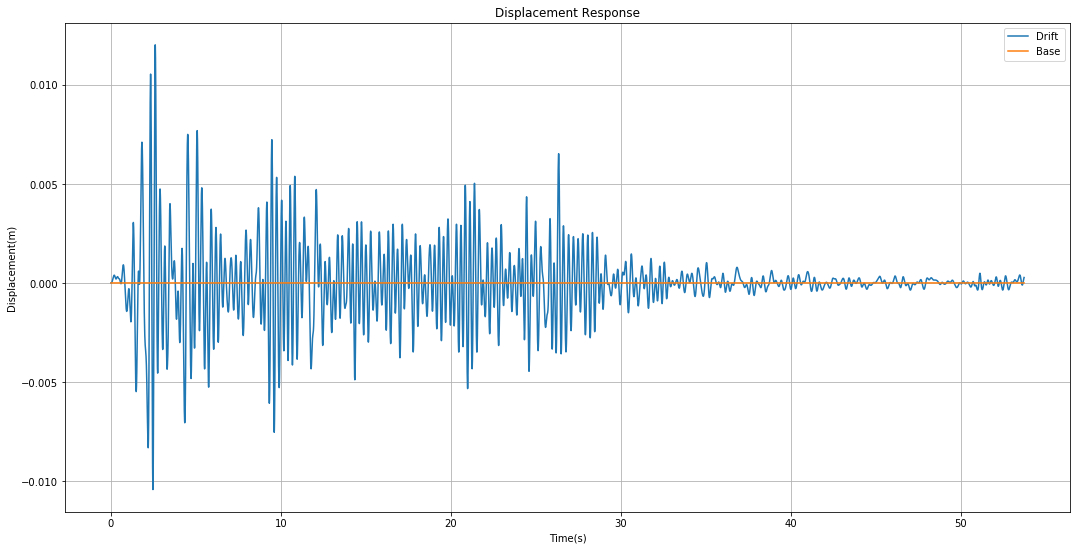

In [100]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, np.array(S1[0]) - np.array(S1[2]))
h2, = ax.plot(t, S1[2])
ax.legend([h1, h2], ['Drift', 'Base'])
ax.set_ylabel('Displacement(m)')
ax.set_xlabel('Time(s)')
ax.grid()
plt.title('Displacement Response')
plt.show()

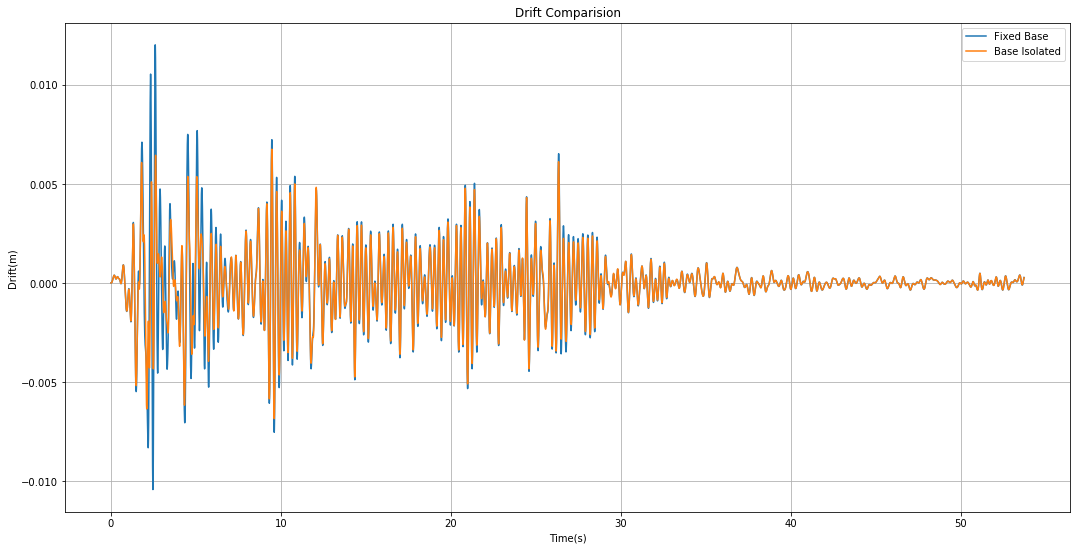

In [101]:
fig = plt.figure(figsize = (18,9))
ax = fig.add_subplot(111)
h1, = ax.plot(t, np.array(S1[0]) - np.array(S1[2]))
h2, = ax.plot(t, np.array(S0[0]) - np.array(S0[2]))
ax.legend([h1, h2], ['Fixed Base', 'Base Isolated'])
ax.set_ylabel('Drift(m)')
ax.set_xlabel('Time(s)')
ax.grid()
plt.title('Drift Comparision')
plt.show()

In [111]:
abs_drift = np.absolute(np.array(S1[0]) - np.array(S1[2]))
drift_max_fix = np.amax(abs_drift) * 1000
time_max = t[np.argmax(abs_drift)]
reduce = (drift_max_fix - drift_max)/drift_max_fix * 100
print(f'Max drift is {drift_max_fix} mm at {time_max}s. {reduce:.2f}% reduction of max drift is observed')

Max drift is 12.022064654231137 mm at 2.603s. 43.02% reduction of max drift is observed
